## Libraries

In [1]:
import os
import glob
import random
import librosa
import librosa.display

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Conv2D, MaxPooling2D, RNN, LSTM, GRU, Flatten, Dropout, ReLU, BatchNormalization, Dense
from tensorflow.keras.activations import tanh, sigmoid, softmax, relu
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



## Preprocess

In [2]:
# Define constants
sample_rate = 16000
Samples = 16000
Dataset = "Dataset_1"

In [3]:
file_names = ["on" ,"off" ,"stop" ,"go"]

In [4]:
# Dataset = "Dataset"
# exclude = {"LICENSE", "README","testing_list", "validation_list"}  

In [5]:
# file_names = [
#     folder for folder in os.listdir(Dataset)
#     if os.path.isdir(os.path.join(Dataset, folder)) and
#     not folder.startswith('_') and
#     folder not in exclude
# ]

In [6]:
# print(file_names)

In [7]:
# folder_path = [os.path.join(Dataset.na) for name in file_names]

In [8]:
# print(folder_path)

In [9]:
def load_audio(path):
    audio, _ = librosa.load(path, sr=sample_rate)
    if len(audio) < Samples:
        audio = np.pad(audio, (0, Samples - len(audio)))  # Fixed padding
    else:
        audio = audio[:Samples]
    return audio

## MEL-Spectrum

In [10]:
# sample_rate = 16000

In [11]:
def get_mel(audio):
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)  
    return mel_spec

In [12]:
# x,y,label_map = load_data()

In [13]:
import numpy
numpy.version.version

'1.25.2'

In [14]:
def load_data():
    x, y = [], []
    label_map = {label: i for i, label in enumerate(file_names)}

    for label in file_names:
        files = glob.glob(os.path.join(Dataset, label, "*.wav"))
        # print(" --" * 5)
        # print("Sample Files 1:")
        # print(" --" * 5)

        for file in files:
            audio = load_audio(file)  # Fixed variable name
            mel_spec = get_mel(audio)
            x.append(mel_spec)
            y.append(label_map[label])
    
    return np.array(x), np.array(y), label_map

In [15]:
# Load data
x, y, label_map = load_data()

In [16]:
import matplotlib.pyplot as plt

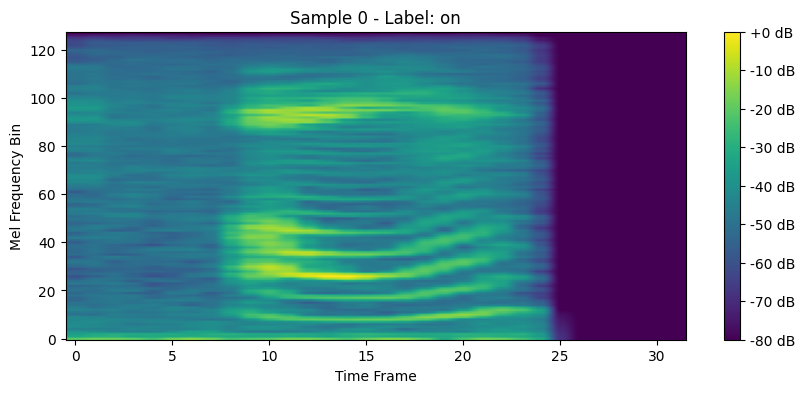

In [17]:

# Plot one sample
def plot_sample(x, y, label_map, index=0):
    plt.figure(figsize=(10, 4))
    plt.imshow(x[index], aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    
    # Get the label from the label map
    label = list(label_map.keys())[list(label_map.values()).index(y[index])]
    plt.title(f"Sample {index} - Label: {label}")
    
    plt.xlabel('Time Frame')
    plt.ylabel('Mel Frequency Bin')
    plt.show()

# Call the plot function
plot_sample(x, y, label_map, index=0)


## Train Test Split

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=32)


In [19]:
print(f"train sample : {len(x_train)}, {len(y_train)}")


train sample : 7580, 7580


In [20]:
x_train = x_train[..., np.newaxis]

## Model

In [21]:
def build_model(input_shape, num_classes):
    model = Sequential([

        Conv2D(32,(3,3), activation = "relu", input_shape = input_shape),
        MaxPooling2D((2,2)),
        Conv2D(64,(3,3),activation = "relu"),
        MaxPooling2D((2,2)),
        Conv2D(128,(3,3),activation = "relu"),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation = "relu"),
        Dropout(0.2),
        Dense(num_classes, activation = "softmax")
     ])
    return model

In [22]:
model = build_model(x_train[0].shape, len(file_names))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 30, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 4, 128)        73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 2, 128)        0

In [24]:
model.compile(optimizer="adam", loss = "sparse_categorical_crossentropy", metrics = ['accuracy'])

In [25]:
early = EarlyStopping(monitor = "val_loss", patience = 5, restore_best_weights = True)

In [26]:
epoch= 20
batch_size = 32

history = model.fit(x_train, y_train, validation_data = (x_test,y_test), epochs = epoch, batch_size = batch_size, callbacks= [early])

Epoch 1/20


237/237 [==============================] - 19s 72ms/step - loss: 1.0298 - accuracy: 0.6189 - val_loss: 0.4159 - val_accuracy: 0.8507
Epoch 2/20
237/237 [==============================] - 17s 72ms/step - loss: 0.3649 - accuracy: 0.8685 - val_loss: 0.2973 - val_accuracy: 0.8903
Epoch 3/20
237/237 [==============================] - 18s 75ms/step - loss: 0.2734 - accuracy: 0.9000 - val_loss: 0.2166 - val_accuracy: 0.9246
Epoch 4/20
237/237 [==============================] - 18s 76ms/step - loss: 0.2004 - accuracy: 0.9256 - val_loss: 0.1908 - val_accuracy: 0.9320
Epoch 5/20
237/237 [==============================] - 18s 75ms/step - loss: 0.1593 - accuracy: 0.9394 - val_loss: 0.1676 - val_accuracy: 0.9399
Epoch 6/20
237/237 [==============================] - 17s 71ms/step - loss: 0.1532 - accuracy: 0.9435 - val_loss: 0.2040 - val_accuracy: 0.9251
Epoch 7/20
237/237 [==============================] - 18s 75ms/step - loss: 0.1161 - accuracy: 0.9566 - val_loss: 0.1714 - val_accurac

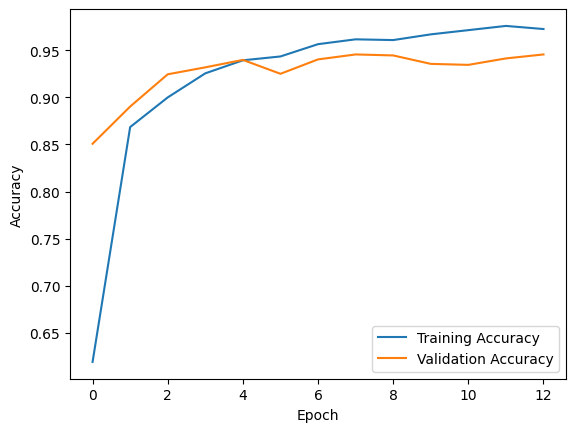

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [28]:
loss, accuracy = model.evaluate(x_train, y_train)
print(f"Training Accuracy: {accuracy:.2f}")


237/237 [==============================] - 4s 17ms/step - loss: 0.0483 - accuracy: 0.9819
Training Accuracy: 0.98


## inference:

In [29]:
index = random.randint(0, len(x_test) - 1)
sample = x_test[index]
true_label = y_test[index]

In [30]:
sample_input = np.expand_dims(sample, axis = 0)

In [31]:
prediction = model.predict(sample_input)
prediction_label = np.argmax(prediction)



1/1 [==============================] - 0s 221ms/step


In [32]:
label_mappppp = {v: k for k, v in label_map.items()}
print(f"Actual Label: {label_mappppp[true_label]}")
print(f"Predicted Label: {label_mappppp[prediction_label]}")


Actual Label: go
Predicted Label: go


In [33]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [34]:
y_pred = np.argmax(model.predict(x_test), axis = 1)

60/60 [==============================] - 1s 14ms/step


In [35]:
print(classification_report(y_test, y_pred, target_names = file_names))

              precision    recall  f1-score   support

          on       0.94      0.95      0.94       457
         off       0.93      0.93      0.93       479
        stop       0.96      0.95      0.96       481
          go       0.95      0.95      0.95       479

    accuracy                           0.95      1896
   macro avg       0.95      0.95      0.95      1896
weighted avg       0.95      0.95      0.95      1896



In [36]:
cm = confusion_matrix(y_test, y_pred)

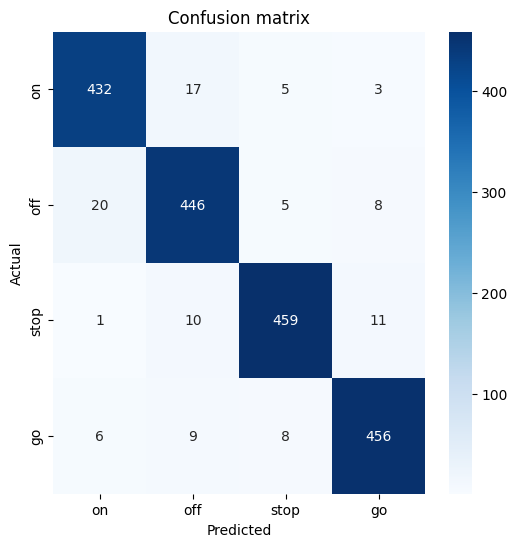

In [37]:
plt.figure(figsize = (6,6))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels= file_names, yticklabels = file_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion matrix")
plt.show()

In [38]:

for i in range(10):
    index = random.randint(0, len(x_test) - 1)
    sample = x_test[index]
    true_label = y_test[index]

    # Add batch dimension
    sample_input = np.expand_dims(sample, axis=0)

    # Predict
    prediction = model.predict(sample_input)
    prediction_label = np.argmax(prediction)

    print(f"Sample {i + 1}:")
    print(f"  Actual Label   : {label_mappppp[true_label]}")
    print(f"  Predicted Label: {label_mappppp[prediction_label]}")
    print("-" * 30)


1/1 [==============================] - 0s 23ms/step
Sample 1:
  Actual Label   : stop
  Predicted Label: stop
------------------------------
1/1 [==============================] - 0s 48ms/step
Sample 2:
  Actual Label   : go
  Predicted Label: go
------------------------------
1/1 [==============================] - 0s 45ms/step
Sample 3:
  Actual Label   : on
  Predicted Label: on
------------------------------
1/1 [==============================] - 0s 43ms/step
Sample 4:
  Actual Label   : on
  Predicted Label: on
------------------------------
1/1 [==============================] - 0s 50ms/step
Sample 5:
  Actual Label   : go
  Predicted Label: go
------------------------------
1/1 [==============================] - 0s 58ms/step
Sample 6:
  Actual Label   : off
  Predicted Label: off
------------------------------
1/1 [==============================] - 0s 50ms/step
Sample 7:
  Actual Label   : on
  Predicted Label: go
------------------------------
1/1 [==============================

In [39]:
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred, average='macro')
print(f"Precision: {precision:.2f}")


Precision: 0.95


In [40]:
from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred, average='macro')
print(f"Recall: {recall:.2f}")


Recall: 0.95


In [41]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1-Score: {f1:.2f}")


F1-Score: 0.95


In [42]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Prediction Accuracy: {accuracy:.2%}")


Prediction Accuracy: 94.57%


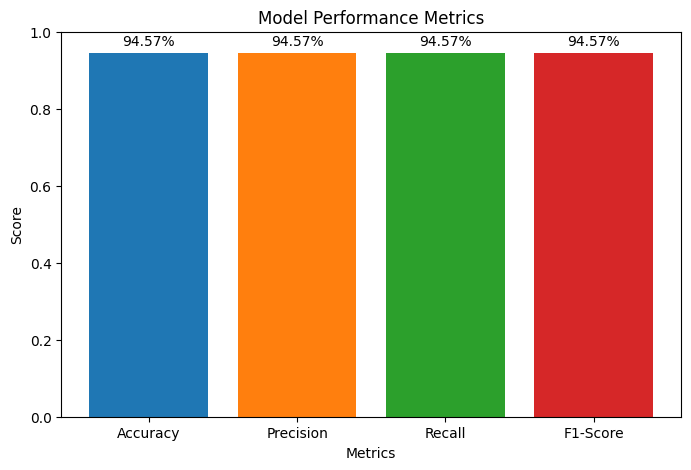

In [43]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
scores = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 5))
plt.bar(metrics, scores, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim(0, 1)  # Set y-axis from 0 to 1
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.xlabel('Metrics')

# Display value on top of each bar
for i, score in enumerate(scores):
    plt.text(i, score + 0.02, f'{score:.2%}', ha='center')

plt.show()